# How Do Skip Connections Work? 


The concept of skip connections was first introduced by He et. al (2015) along with the ResNet architecture. This built upon the concept of highway networks, which allowed gated connections between layers. These breakthroughs made it possible to train much deeper networks with 100s of layers.

A 'skip connection' simply means that the input of the current layer or block of layers is added back to the output of the block. 

$$
x' = x + f(x) 
$$


However, it wasn't till 2018 (Li et. al) that it was understood why this improvement helped train deep networks.
So why does this work? To understand we will train two deep CNNs, each with 50 layers. The second (candidate) model will implement skip connections after each CNN filter. 





## Let's Start by Looking at our Dataset


The CIFAR-10 dataset is a popular benchmark for machine learning and computer vision tasks, consisting of 60,000 32x32 color images across 10 distinct classes. Each image is labeled as one of the following categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck. The dataset is divided into 50,000 training images and 10,000 test images, with an even distribution of 6,000 images per class.

Despite its simplicity, the dataset contains a variety of object poses, lighting conditions, and backgrounds, making it non-trivial to achieve high accuracy.


Convolutional Neural Networks and other image-specific architectures are typically trained on this dataset. However, for this experiment, we will use a feedforward network in order to demonstrate the benefits of using dropout.

In [61]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

train_tf, test_tf = tfds.load('cifar10', split=['train', 'test'], batch_size=-1, as_supervised=True)

raw_train_images, train_labels = train_tf[0], train_tf[1]
raw_train_images = jnp.float32(raw_train_images)
raw_train_images = raw_train_images.reshape((raw_train_images.shape[0], -1))
train_labels = jnp.float32(train_labels)

raw_test_images, test_labels = test_tf[0], test_tf[1]
raw_test_images = jnp.float32(raw_test_images)
raw_test_images = raw_test_images.reshape((raw_test_images.shape[0], -1))
test_labels = jnp.float32(test_labels)

print(f"Training Set Size {raw_train_images.shape[0]}")
print(f"Test Set Size {raw_test_images.shape[0]}")

Training Set Size 50000
Test Set Size 10000


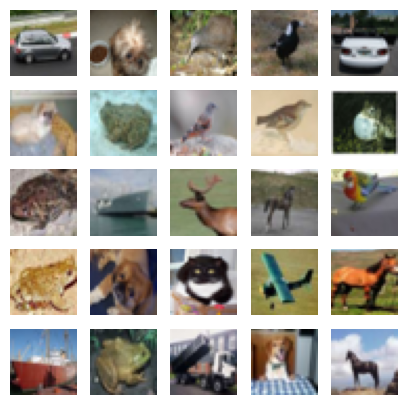

In [62]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-v0_8-darkgrid')

RANDOM_KEY = 42

num_examples = 25
row_size = int(math.sqrt(num_examples))
fig, axs = plt.subplots(row_size, row_size, figsize=(row_size,row_size))

rng = jax.random.PRNGKey(RANDOM_KEY)
idxs = jax.random.randint(rng, (num_examples,), 0, raw_train_images.shape[0])
exs = raw_train_images[idxs,:].reshape((num_examples,32,32,3))/255.0

for ex in range(num_examples):
    i = ex // row_size
    j = ex % row_size
    axs[i,j].imshow(exs[ex])
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].set_xmargin(0)
    axs[i,j].set_ymargin(0)

plt.show()

## Let's train a ResNet (NoSkip) network on CIFAR 10

In [73]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn
from flax.training import train_state
import tensorflow_datasets as tfds

# Load CIFAR-10 dataset
def load_data():
    def preprocess_fn(batch):
        image = batch['image'] / 255.0  # Normalize images to [0, 1]
        label = batch['label']
        return image, label

    ds_train, ds_test = tfds.load(
        'cifar10', split=['train', 'test'], as_supervised=False, batch_size=-1
    )
    train_data = tfds.as_numpy(ds_train)
    test_data = tfds.as_numpy(ds_test)

    train_images, train_labels = preprocess_fn(train_data)
    test_images, test_labels = preprocess_fn(test_data)

    mean = jnp.mean(train_images)
    std = jnp.std(train_images)

    train_images = (train_images - mean) / std
    test_images = (test_images - mean) / std

    return train_images, train_labels, test_images, test_labels


# Define the CNN model
class SimpleCNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        #print(x.shape)
        x = nn.Conv(features=32, kernel_size=(3, 3))(x) # padding defaults to "SAME"
        x = nn.relu(x)
        #print(x.shape)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        #print(x.shape)
        #print('---')

        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        #print(x.shape)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        #print(x.shape)
        #print('===')

        x = x.reshape((x.shape[0], -1))  # Flatten the tensor
        #print(x.shape)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        #print(x.shape)
        x = nn.Dense(features=10)(x)  # 10 classes for CIFAR-10
        #print(x.shape)
        #print('ooo')
        return x

# Define the CNN model
class DeeperCNN(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool, rng=rng):
        # Block 1
        x = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))  # Downsample
        
        # Block 2
        x = nn.Conv(features=64, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))  # Downsample

        # Block 3
        x = nn.Conv(features=128, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Conv(features=128, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))  # Downsample

        # Fully Connected Layers
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5)(x, deterministic=False, rng=rng)  # Dropout for regularization
        x = nn.Dense(features=10)(x)  # Output layer for 10 classes

        return x



# Create the train state
def create_train_state(rng, cnn, learning_rate):
    variables = cnn.init(rng, jnp.ones([1, 32, 32, 3]), train=True, rng=rng)
    params= variables['params']
    batch_stats = variables['batch_stats']

    #tx = optax.chain(
    #    optax.clip_by_global_norm(1.0),  # Gradient clipping
    #    optax.adam(learning_rate)
    #)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx), batch_stats


# Define the training and evaluation steps
@jax.jit
def train_step(state, batch, batch_stats):
    images, labels = batch

    def loss_fn(params, batch_stats):
        logits, batch_stats = state.apply_fn({'params': params, 'batch_stats': batch_stats}, images, train=True, mutable=["batch_stats"])
        one_hot = jax.nn.one_hot(labels, num_classes=10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits, one_hot))
        return loss, batch_stats

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    outputs, grads = grad_fn(state.params, batch_stats)
    loss, updated_batch_stats = outputs
    grads_flat = jax.tree_util.tree_flatten(grads)[0][2]
    grad_norm = jnp.linalg.norm(grads_flat)
    state = state.apply_gradients(grads=grads)
    return state, loss, updated_batch_stats


@jax.jit
def eval_step(state, batch, batch_stats):
    images, labels = batch
    logits, batch_stats = state.apply_fn({'params': state.params, 'batch_stats': batch_stats}, images, train=False, mutable=["batch_stats"])
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy


# Training loop
def train_and_evaluate(model, num_epochs, batch_size, learning_rate):
    train_images, train_labels, test_images, test_labels = load_data()
    rng = jax.random.PRNGKey(0)

    # Create the train state
    state, batch_stats = create_train_state(rng, model, learning_rate)

    # Prepare data batches
    for epoch in range(num_epochs):

        train_batches = zip(
            jnp.array_split(train_images, len(train_images) // batch_size),
            jnp.array_split(train_labels, len(train_labels) // batch_size),
        )
        test_batches = zip(
            jnp.array_split(test_images, len(test_images) // batch_size),
            jnp.array_split(test_labels, len(test_labels) // batch_size),
        )

        # Training
        train_losses = []
        for batch in train_batches:
            state, loss, batch_stats = train_step(state, batch, batch_stats)
            train_losses.append(loss)

        # Evaluation
        accuracies = []
        for batch in test_batches:
            accuracy = eval_step(state, batch, batch_stats)
            accuracies.append(accuracy)

        # Compute mean loss
        mean_epoch_loss = jnp.mean(jnp.array(train_losses))
        # Compute mean accuracy
        test_accuracy = jnp.mean(jnp.array(accuracies))  # Convert to JAX array
        print(f"Epoch {epoch + 1}, Train Loss: {mean_epoch_loss}, Test Accuracy: {test_accuracy:.4f}")

    return state


# Run the training
model = DeeperCNN()
trained_state = train_and_evaluate(model=model, num_epochs=20, batch_size=64, learning_rate=0.001)


## Next, Let's train a ResNet with Skip Connections 

## So Why do Skip Connections Work?

### Let's Plot the Loss Surfaces

### References:

1. Highway networks - Srivastava et. al (2015)
2. "Deep Residual Learning for Image Recognition" by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun, published in 2015
2. ON LARGE-BATCH TRAINING FOR DEEP LEARNING: GENERALIZATION GAP AND SHARP MINIMA - Keskar et. al
3. An empirical analysis of the optimization of deep network loss surfaces - Im et. al (2017)
4. Hao Li1, Zheng Xu1, Gavin Taylor2, Christoph Studer3, Tom Goldstein1 - Visualizing the Loss Landscape of Neural Nets (2018)